<a href="https://colab.research.google.com/github/JustinShawAhn/PyTorch-Learning/blob/main/02_PyTorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with PyTorch

A very similar and inspired article of [Neural Networks](https://madewithml.com/courses/foundations/neural-networks/)


## What is a classification problem?

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example:

| Problem type | What is it? | Example |
| ----- | ----- | ----- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy). |





## 0. Architecture of a classification neural network

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

## 1. Make classification data and get it ready

Begin by making some data.

Using the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


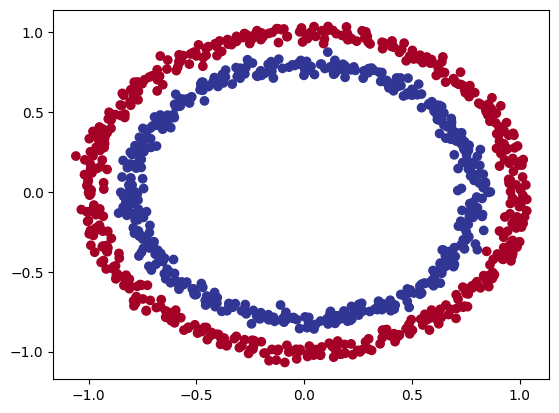

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

> **Note:** This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.

Here are more [**toy datasets**](https://scikit-learn.org/stable/datasets/toy_dataset.html) found in `scikit learn`.

### 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in models.

Asking the question:
"What shapes are my inputs and what shapes are my outputs?"


In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

The second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar).

We have two inputs for one output.
1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float) # converting from float 64 to 32
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from Scikit-Learn.

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop

start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.



In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We'll want a model capable of handling our `X` data as inputs and producing something in the shape of our `y` data as ouputs.

In other words, given `X` (features) we want our model to predict `y` (label).

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.



In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

[TensorFlow Playground website](https://playground.tensorflow.org/) is a website where you could visualize Neural Networks.

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

doing the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

In [12]:
# Replicate CircleModelV0 with nn.Sequential (it is overridding)
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it *always* runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0682],
        [-0.0256],
        [-0.1182],
        [ 0.1227],
        [-0.8040],
        [-0.8559],
        [-0.5763],
        [-0.7725],
        [-0.0890],
        [-0.0394]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


there's the same amount of predictions as there is test labels **but the predictions don't look like they're in the same form or shape as the test labels.**

Before fitting it into the model, we must fix that.

### 2.1 Setup loss function and optimizer


for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

For a **binary classification** problem, often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`).

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) |
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in.

The documentation for [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4).

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.





In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

There are several evaluation metrics that can be used for classification problems but let's start out with **accuracy**.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

PyTorch training loop steps
1. **Forward pass** - The model goes through all of the training data once, performing its `forward()` function calculations (`model(x_train)`).

2. **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (`loss = loss_fn(y_pred, y_train`)).

3. **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (`optimizer.zero_grad()`).

4. **Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).

5. **Step the optimizer (gradient descent)** - Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).




### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the `forward()` method).

To do so, let's pass the model some data.

In [16]:
# View the frist 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0682],
        [-0.0256],
        [-0.1182],
        [ 0.1227],
        [-0.8040]], device='cuda:0')

Since our model hasn't been trained, these outputs are basically random.

They're the output of our `forward()` method.

Which implements two layers of `nn.Linear()` which internally calls the following equation:

$$
\mathbf{y} = x \cdot \mathbf{Weights}^T  + \mathbf{bias}
$$

The *raw outputs* (unmodified) of this equation ($\mathbf{y}$) and in turn, the raw outputs of our model are often referred to as [**logits**](https://datascience.stackexchange.com/a/31045).

That's what our model is outputing above when it takes in the input data ($x$ in the equation or `X_test` in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the [sigmoid activation function](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).


In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5170],
        [0.4936],
        [0.4705],
        [0.5306],
        [0.3092]], device='cuda:0')

They're now in the form of **prediction probabilities**

in other words, the values are now how much the model thinks the data point belongs to one class or another.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:
* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.



In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 0., 1., 0.], device='cuda:0')

Now it looks like our model's predictions are in the same form as our truth labels (`y_test`).

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our models predictions to the test labels to see how well it's going.

STEPS:
To recap, we converted our model's raw outputs (logits) to predicition probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

> The use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### 3.2 Building a training and testing loop

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [20]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.72607, Accuracy: 47.62% | Test loss: 0.72321, Test acc: 44.50%
Epoch: 10 | Loss: 0.71138, Accuracy: 48.50% | Test loss: 0.71089, Test acc: 45.00%
Epoch: 20 | Loss: 0.70417, Accuracy: 49.38% | Test loss: 0.70483, Test acc: 46.50%
Epoch: 30 | Loss: 0.70027, Accuracy: 49.38% | Test loss: 0.70151, Test acc: 47.00%
Epoch: 40 | Loss: 0.69798, Accuracy: 49.75% | Test loss: 0.69951, Test acc: 49.50%
Epoch: 50 | Loss: 0.69654, Accuracy: 49.12% | Test loss: 0.69820, Test acc: 51.00%
Epoch: 60 | Loss: 0.69558, Accuracy: 49.38% | Test loss: 0.69729, Test acc: 50.00%
Epoch: 70 | Loss: 0.69492, Accuracy: 49.75% | Test loss: 0.69664, Test acc: 50.50%
Epoch: 80 | Loss: 0.69444, Accuracy: 49.50% | Test loss: 0.69614, Test acc: 50.50%
Epoch: 90 | Loss: 0.69409, Accuracy: 49.75% | Test loss: 0.69577, Test acc: 50.50%


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make predictions and evaluate the model
From the metrics it looks like our model is random guessing.

making a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the [`helper_functions.py` script](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py)

It contains a helpful function called `plot_decision_boundary()` which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

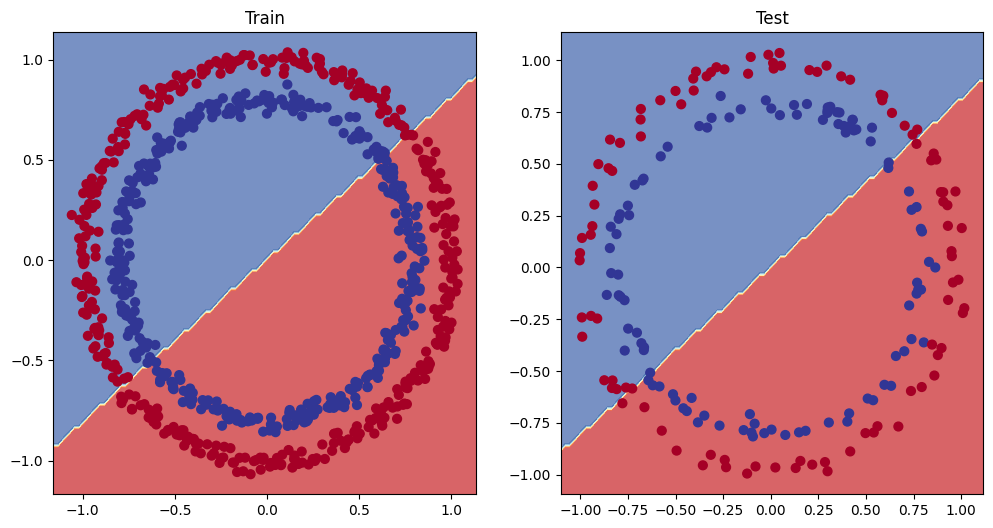

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

## 5. Improving a model (from a model perspective)

Let's try to fix our model's underfitting problem.

Focusing specifically on the model (not the data), there are a few ways we could do this.

| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. See [Article](https://www.analyticsvidhya.com/blog/2021/06/the-challenge-of-vanishing-exploding-gradients-in-deep-neural-networks/)|
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem.|

> **Note:** because you can adjust all of these by hand, they're referred to as **hyperparameters**.

Let's see what happens if we add an extra layer to our model, fit for longer (`epochs=1000` instead of `epochs=100`) and increase the number of hidden units from `5` to `10`.

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

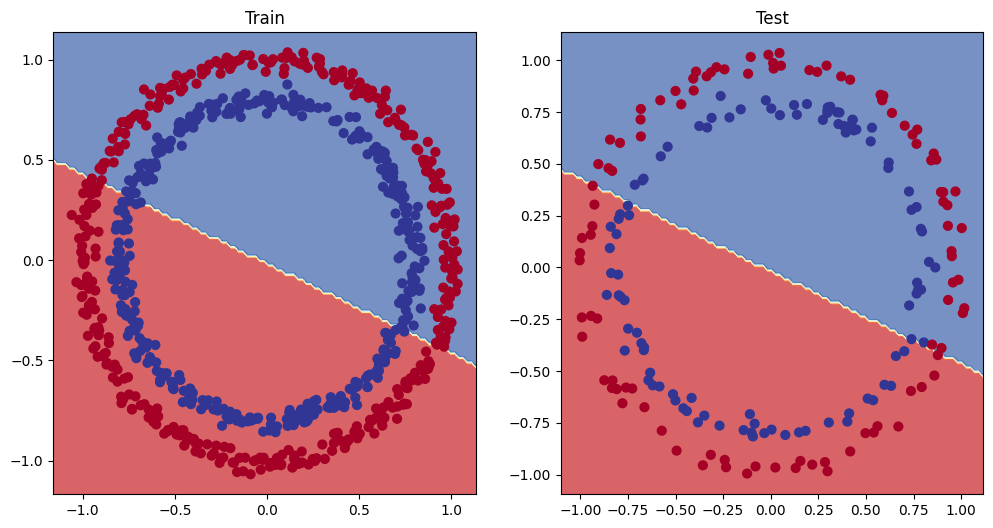

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.



In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


let's see how the data looks.

To do so, we'll use the `plot_predictions()` function we created in notebook 01.



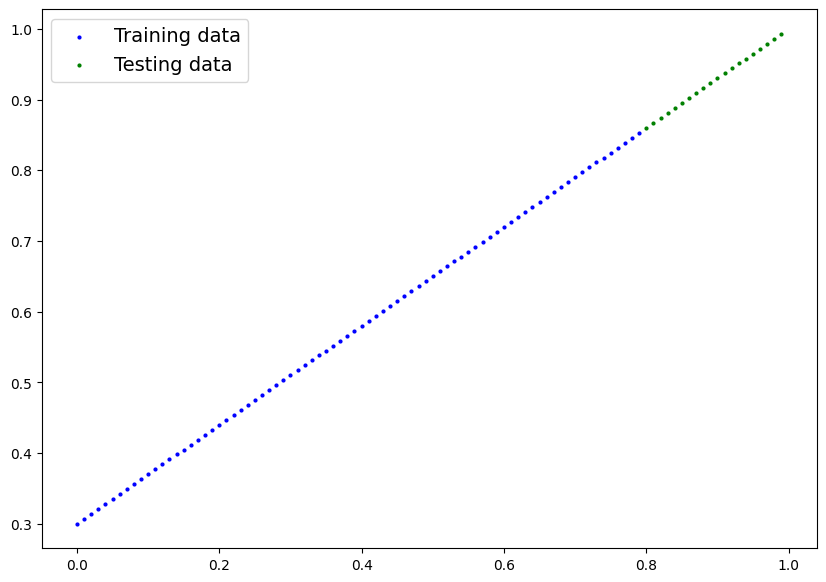

In [29]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 Adjusting `model_1` to fit a straight line

Now we've got some data, let's recreate `model_1` but with a loss function suited to our regression data.

In [30]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10), # it's important for our `in_features` to be 1, not 2 as before.
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

We'll setup the loss function to be `nn.L1Loss()` (the same as mean absolute error) and the optimizer to be `torch.optim.SGD()`.

In [31]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

> **Note:** I have been writing similar training loop code over and over again. I've made it that way on purpose though, to keep practicing. However, this can be functionized. Potentially there could be a function for training and a function for testing.

In [32]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


unlike `model_1` on the classification data, it looks like `model_2`'s loss is actually going down.

Let's plot its predictions to see if that's so.

And remember, since our model and data are using the target `device`, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) when we pass it to `plot_predictions()`.

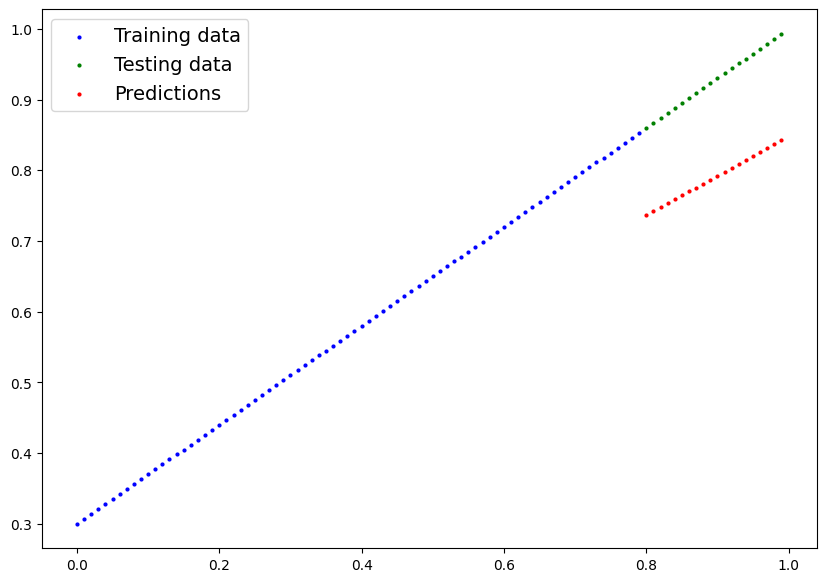

In [33]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

## 6.1 Recreating non-linear data (red and blue circles)

First, let's recreate the data to start off fresh. We'll use the same setup as before.

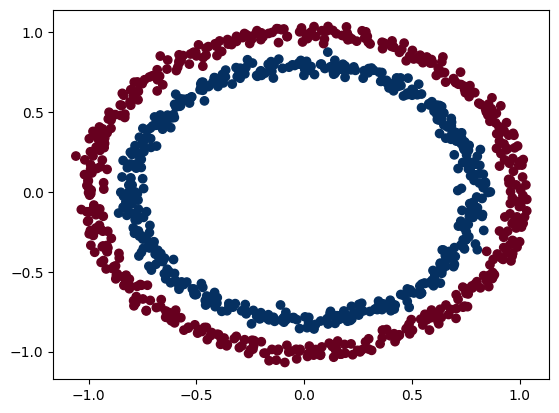

In [34]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

Now let's split it into training and test sets using 80% of the data for training and 20% for testing.

In [35]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

The data we've been working with is non-linear (circles).

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [36]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


> **Question:** *Where should I put the non-linear activation functions when constructing a neural network?*
>
> A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantine, best to experiment, experiment, experiment.

In [37]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [38]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [39]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

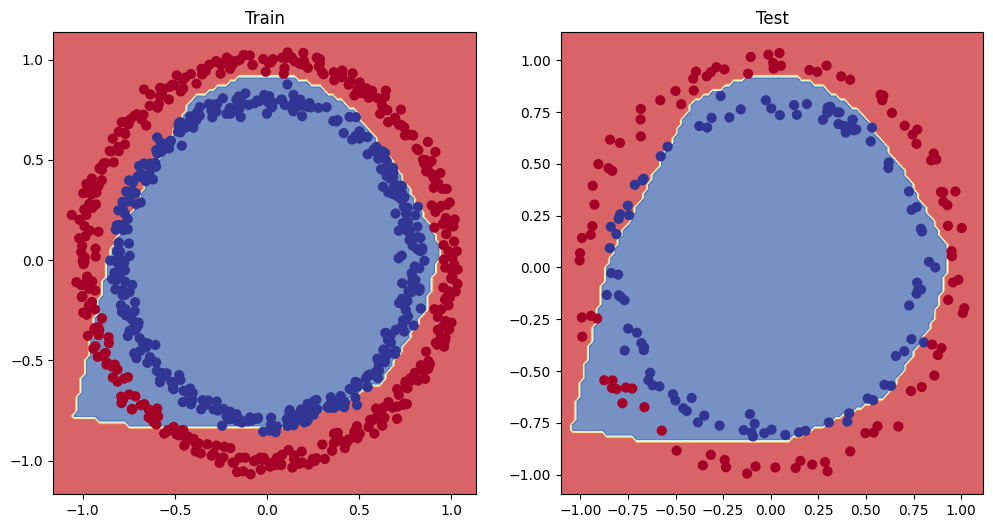

In [61]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

> **Note:** Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation *look* like?

In [41]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

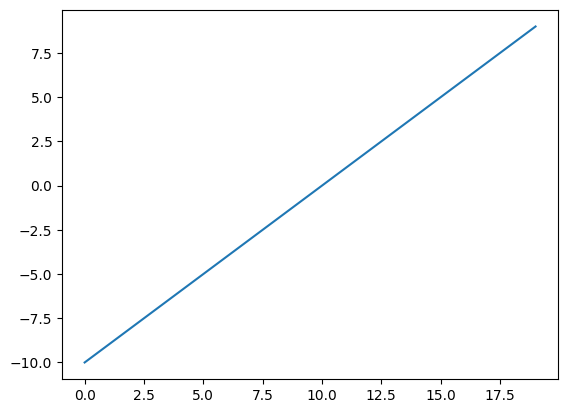

In [42]:
# Visualize the toy tensor
plt.plot(A);

A straight line.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (`torch.nn.ReLU`), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [43]:
# Create ReLU function by hand
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

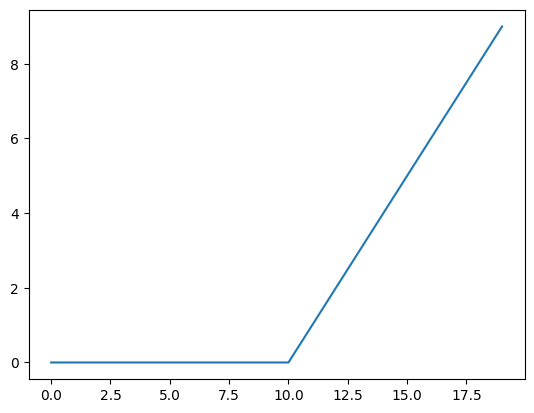

In [44]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

How about we try the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) we've been using?

The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for [exponential](https://en.wikipedia.org/wiki/Exponential_function) ([`torch.exp()`](https://pytorch.org/docs/stable/generated/torch.exp.html)) and $i$ stands for a particular element in a tensor.

In [45]:
# Create a custom sigmoid function
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

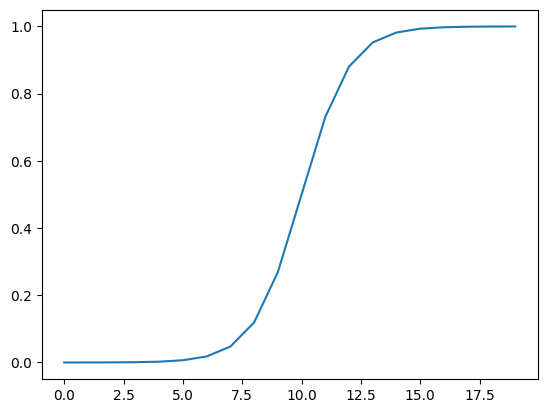

In [46]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

We've gone from a straight line to a curved line.

Now there's plenty more [non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that exist in PyTorch that we haven't tried.

But these two are two of the most common.

## 8. Putting things together by building a multi-class PyTorch model

But now let's put it all together using a multi-class classification problem.

Recall a **binary classification** problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo)
where as a **multi-class classification** problem deals with classifying something from a list of *more than* two options (e.g. classifying a photo as a cat a dog or a chicken).

multi-class classification can deal with any number of classes over two, for example, the popular [ImageNet-1k dataset](https://www.image-net.org/) is used as a computer vision benchmark and has 1000 classes.

### 8.1 Creating mutli-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


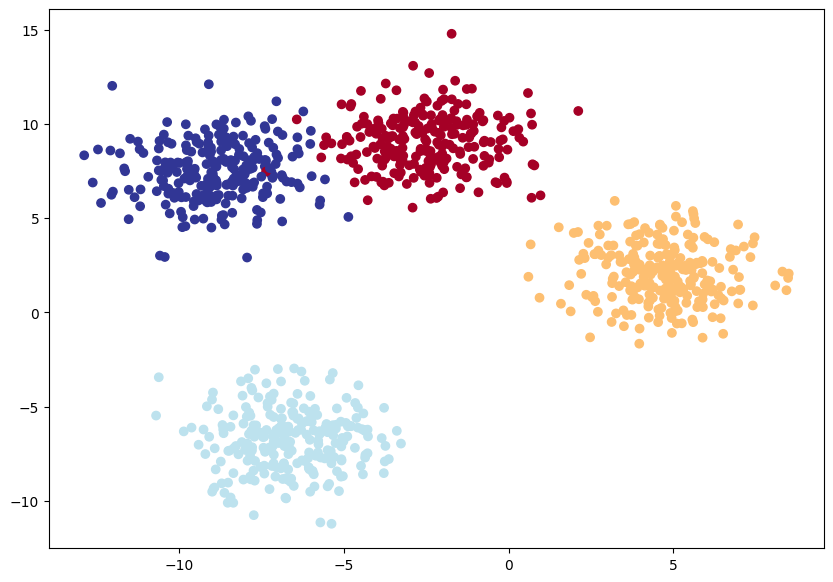

In [47]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

we build one similar to `model_3` but this still capable of handling multi-class data?

To do so, let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.

Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder).

Then we'll create the model class using the hyperparameters above.

In [48]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [50]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

We've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [51]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [52]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Good. Our model is predicting one value for each class that we have.

However, these are raw ouputs of our model, called **logits**.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from `logits -> prediction probabilities -> prediction labels` just like we did with the binary classification problem?

That's where we use [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function)

In [53]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [54]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

These prediction probablities are essentially saying how much the model *thinks* the target `X` sample (the input) maps to each class.

We can check which index has the highest value using `torch.argmax()`.

In [55]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

In [56]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [57]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

Looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (`y_blob_test`) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using `torch.softmax()`) then to prediction labels (by taking the `argmax()` of each sample).

> **Note:** It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.
>
> For example, `y_preds = torch.argmax(y_logits, dim=1)`, this saves a computation step (no `torch.softmax()`) but results in no prediction probabilities being available to use.

In [58]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).



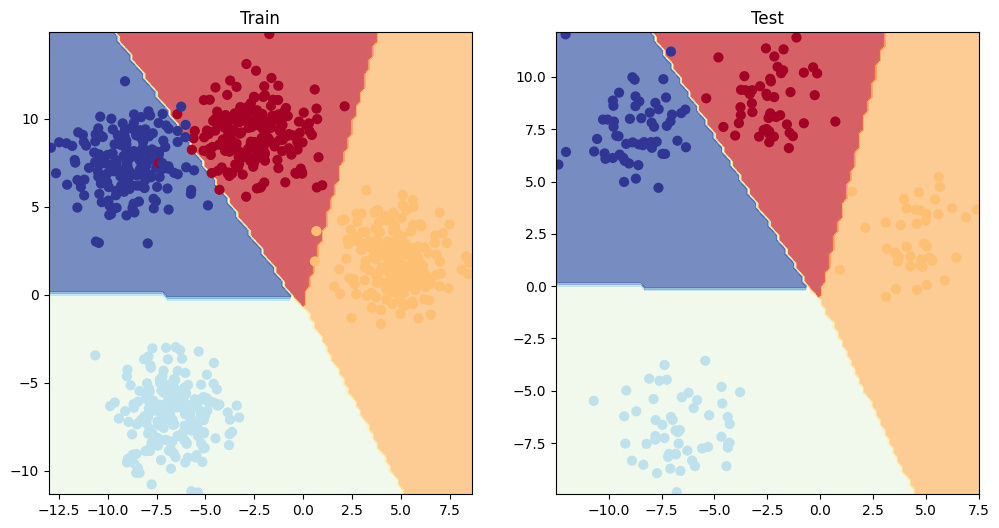

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html).

Let's try the `torchmetrics.Accuracy` metric out.

See this [article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) for Precision and Recall.

In [62]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')